In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

from src.utility.h5_serializable_file import H5Serializable
import src.utility.utils as utils 
from uncertainties import ufloat
from src.photometry_data import PhotometryData
from src.utility.run_cfg import ErebusRunConfig
from src.erebus import Erebus
from src.utility.utils import bin_data
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ErebusRunConfig.save_schema("../src/schema/run_cfg_schema.json")

In [3]:
#lhs1478b = Erebus(ErebusRunConfig.load("./run_cfgs/lhs1478b.yaml"))
#trappist1b = Erebus(ErebusRunConfig.load("./run_cfgs/trappist1b.yaml"))
#trappist1c = Erebus(ErebusRunConfig.load("./run_cfgs/trappist1c.yaml"))
lhs1478b = Erebus(ErebusRunConfig.load("./run_cfgs/lp791-18d.yaml"))

Eccentric orbit: using uniform prior for t_sec
Visit jw06457004001 was already run


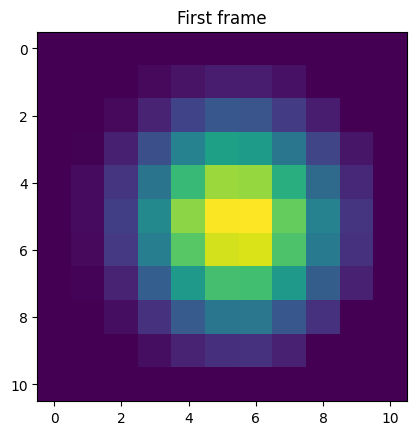

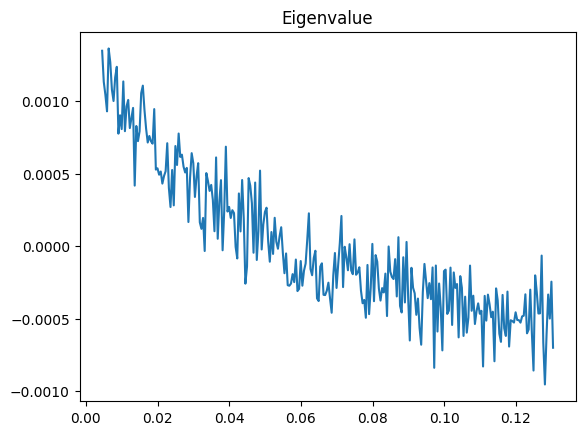

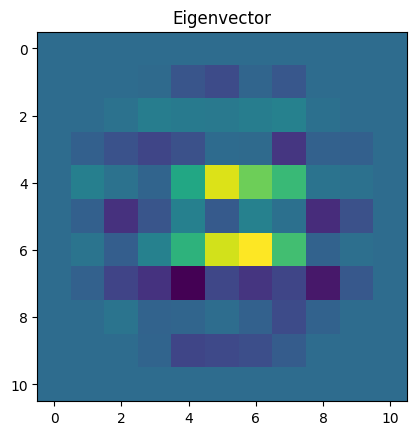

In [4]:
# DO PLOTTING
from src.frame_normalized_pca import perform_fn_pca_on_aperture

fit = lhs1478b.individual_fits[0]

plt.imshow(lhs1478b.photometry[0].normalized_frames[2])
plt.title("First frame")
plt.show()

eigenvalues = fit.eigenvalues
eigenvectors = fit.eigenvectors
time = fit.time

#eigenvalues, eigenvectors = perform_fn_pca_on_aperture(trappist1b.photometry[0].normalized_frames[10:-10])

plt.plot(time, eigenvalues[0])
plt.title("Eigenvalue")
plt.show()

plt.imshow(eigenvectors[0])
plt.title("Eigenvector")
plt.show()

[6.74402889e-02 2.00000000e-04 2.45877216e+06 5.19200000e-02
 2.38000000e+01 2.75343600e+00 8.93400000e+01 1.50000000e-03
 0.00000000e+00 1.00000000e-01 1.00000000e-01 1.00000000e-01
 1.00000000e-01 1.00000000e-01 0.00000000e+00 0.00000000e+00
 1.00000000e-03 1.00000000e-06]


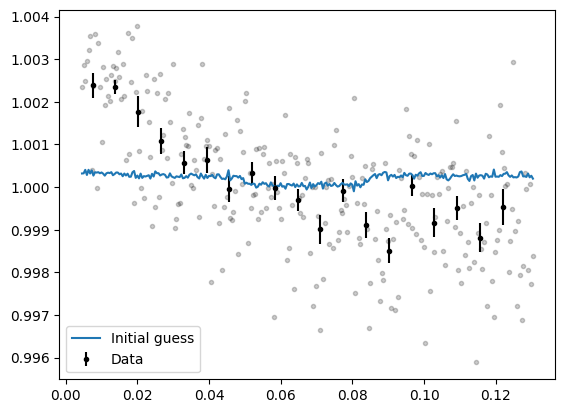

In [5]:
fit = lhs1478b.individual_fits[0]

flux = fit.raw_flux
binned_flux, binned_flux_err = bin_data(flux, 14)
binned_time, _ = bin_data(time, 14)

mcmc = fit.mcmc
initial_guess = np.array([mcmc.params[p].value for p in mcmc.params])[:-1]
print(initial_guess)
flux_model = fit.fit_method(time, *initial_guess)

plt.plot(time, flux, marker='.', linestyle='', alpha=0.2, color='black')
plt.errorbar(binned_time, binned_flux, yerr=binned_flux_err, marker='.', linestyle='', color='black', label="Data")
plt.plot(time, flux_model, label="Initial guess")
plt.legend()
plt.show()

In [6]:
lhs1478b.run()

jw06457004001 already ran


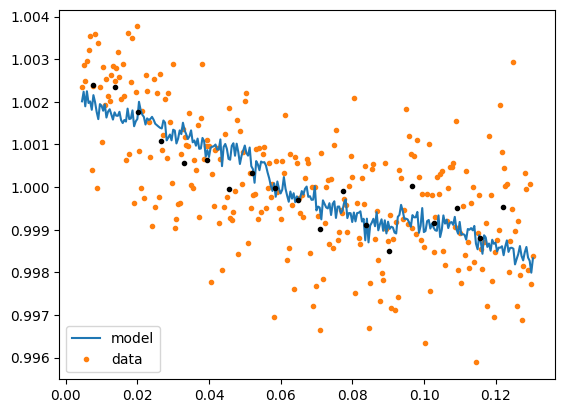

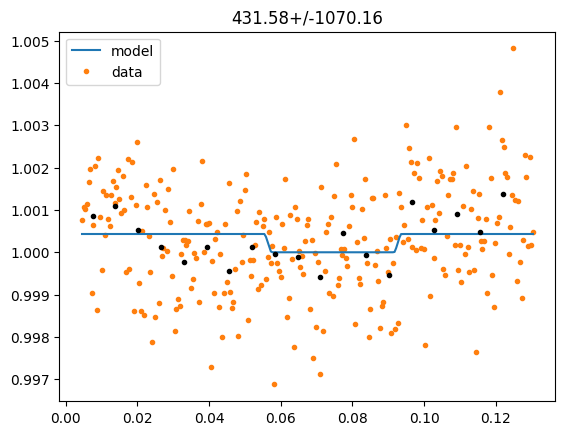

431.57693502802175


In [8]:
import matplotlib.pyplot as plt

def plot(ind):
	fit = lhs1478b.individual_fits[ind]
	
	res = fit.results
	res_nominal_values = [res[k].nominal_value for k in res][:-1]
	physical_params = res_nominal_values[:9]
	systematic_params = res_nominal_values[9:]
	
	t = fit.time
	f = fit.raw_flux
	binned_flux, binned_flux_err = bin_data(f, 14)
	binned_time, _ = bin_data(t, 14)
	f_model = fit.fit_method(t, *res_nominal_values)
	
	plt.plot(t, f_model, label='model', zorder=3)
	plt.plot(t, f, linestyle='', marker='.', label='data')
	plt.plot(binned_time, binned_flux, linestyle='', marker='.', color='black', zorder=4)
	plt.legend()
	plt.show()
	
	f_systematic = fit.systematic_model(t, *systematic_params)
	binned_f_systematic, _ = bin_data(f_systematic, 14)
	plt.plot(t, f_model / f_systematic, label='model', zorder=3)
	plt.plot(t, f / f_systematic, linestyle='', marker='.', label='data')
	plt.plot(binned_time, binned_flux / binned_f_systematic, linestyle='', marker='.', color='black', zorder=4)
	plt.title(f"{res['fp'].nominal_value*1e6:0.2f}+/-{res['fp'].std_dev*1e6:0.2f}")
	plt.legend()
	plt.show()
	
	print(res['fp'].nominal_value*1e6)

plot(0)
#plot(1)

/tmp/ipykernel_512011/3073058274.py:4: DeprecationWarning: Please import `uniform_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import uniform_filter1d


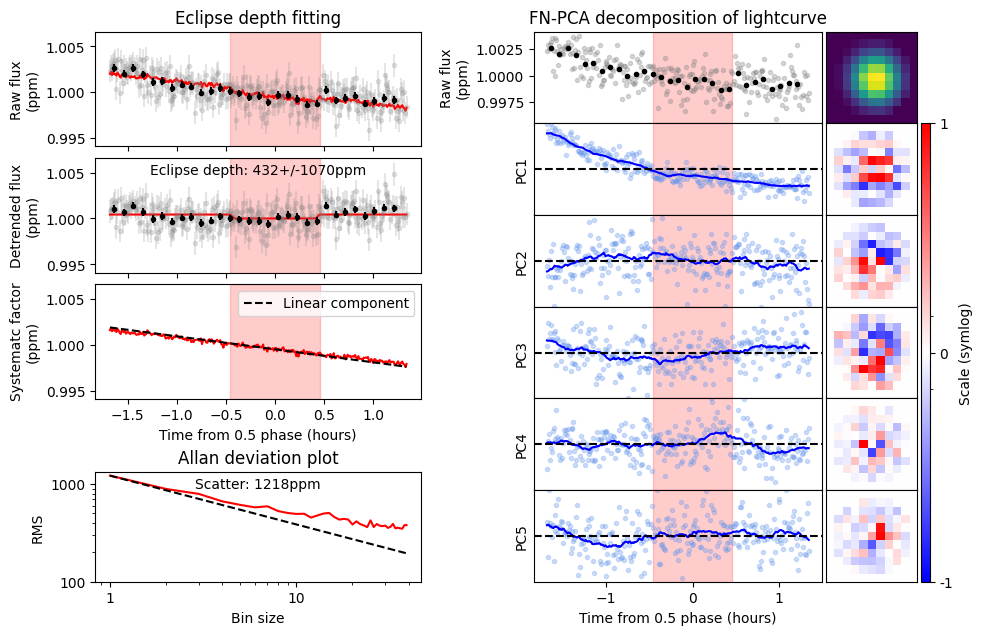

In [9]:
from src.utility.utils import bin_data
from src.utility.utils import get_eclipse_duration
import matplotlib.colors as colors
from scipy.ndimage.filters import uniform_filter1d
from pathlib import Path
from src.individual_fit import IndividualFit

def plot_individual_fit(individual_fit : IndividualFit, save_to_path : str = None):
	'''
	Will save both a png and a pdf
	'''
	yerr = individual_fit.results['y_err'].nominal_value
	t_sec = individual_fit.results['t_sec'].nominal_value
	rp = individual_fit.results['rp_rstar'].nominal_value
	inc = individual_fit.results['inc'].nominal_value
	a = individual_fit.results['a_rstar'].nominal_value
	per = individual_fit.results['p'].nominal_value
	fp = individual_fit.results['fp'].nominal_value
	fp_err = individual_fit.results['fp'].std_dev

	raw_time = individual_fit.time
	time = (raw_time - t_sec) * 24 # hours
	flux = individual_fit.raw_flux
	
	bin_size = len(time) // 30
	bin_time, _ = bin_data(time, bin_size)
	bin_flux, _ = bin_data(flux, bin_size)
	bin_yerr = yerr / np.sqrt(bin_size)
	duration = get_eclipse_duration(inc, a, rp, per) * 24
	res_nominal_values = [individual_fit.results[k].nominal_value for k in individual_fit.results][:-1]
	physical_params = res_nominal_values[:9]
	systematic_params = res_nominal_values[9:]
	flux_model = fit.fit_method(raw_time, *res_nominal_values)
	flux_model_detrended = fit.physical_model(raw_time, *physical_params)
	systematic_factor = fit.systematic_model(raw_time, *systematic_params)
	
	fig = plt.figure(figsize=(9, 5.5))
	grid = fig.add_gridspec(4, 2)
	
	############################################################################## Layout
	flux_subfigure = fig.add_subfigure(grid[0:3,0])
	allan_deviation_subfigure = fig.add_subfigure(grid[3,0])
	pca_subfig = fig.add_subfigure(grid[:,1:])
	
	flux_gridspec = flux_subfigure.add_gridspec(3, 1, wspace=0, hspace=0.1)
	flux_gridspec.update(top=1.0, right=0.85)
	flux_axs = flux_gridspec.subplots(sharex=True, sharey=True)
	flux_axs[0].set_title("Eclipse depth fitting")
	flux_axs[2].set_xlabel("Time from 0.5 phase (hours)")
	
	allan_gs = allan_deviation_subfigure.add_gridspec(1, 1)
	allan_gs.update(bottom=0.0, top=0.8, right=0.85)
	allan_ax = allan_gs.subplots()
	allan_ax.set_title("Allan deviation plot")
	
	eigenvalue_gs = pca_subfig.add_gridspec(6,1, hspace=0.0, wspace=0.1)
	eigenvalue_axs = eigenvalue_gs.subplots(sharex=True, sharey=False)
	eigenvalue_gs.update(left=0.1, right=0.74, top=1.0, bottom=0)
	eigenvalue_axs[0].set_title("FN-PCA decomposition of lightcurve")
	eigenvalue_axs[-1].set_xlabel("Time from 0.5 phase (hours)")
	
	eigenimage_gs = pca_subfig.add_gridspec(6,1, hspace=0.0, wspace=0)
	eigenimage_gs.update(left=0.74, right=0.96, top=1.0, bottom=0)
	eigenimage_axs = eigenimage_gs.subplots(sharex=True, sharey=False)

	############################################################################## Fluxes

	# Raw Flux
	flux_axs[0].errorbar(time, flux, yerr, linestyle='', marker='.', alpha = 0.2, color='gray')
	flux_axs[0].errorbar(bin_time, bin_flux, bin_yerr, linestyle='', marker='.', color='black', zorder=3)
	flux_axs[0].axvspan(- duration / 2, duration / 2, color='red', alpha=0.2)
	flux_axs[0].plot(time, flux_model, color='red')
	flux_axs[0].set_ylabel("Raw flux\n(ppm)")

	# Detrended flux
	detrended_flux = flux / systematic_factor
	bin_detrended_flux, _ = bin_data(detrended_flux, bin_size)
	flux_axs[1].errorbar(time, detrended_flux, yerr, linestyle='', marker='.', alpha = 0.2, color='gray')
	flux_axs[1].errorbar(bin_time, bin_detrended_flux, bin_yerr, linestyle='', marker='.', color='black', zorder=3)
	flux_axs[1].axvspan(- duration / 2, duration / 2, color='red', alpha=0.2)
	flux_axs[1].plot(time, flux_model / systematic_factor, color='red')
	flux_axs[1].set_ylabel("Detrended flux\n(ppm)")
	flux_axs[1].text(0.5, 0.95, f"Eclipse depth: {fp*1e6:0.0f}+/-{fp_err*1e6:0.0f}ppm", horizontalalignment='center', verticalalignment='top', transform=flux_axs[1].transAxes)

	# Systematic factor
	linear_component = individual_fit.results['a'].nominal_value * raw_time + individual_fit.results['b'].nominal_value + 1
	flux_axs[2].plot(time, systematic_factor, color='red')
	flux_axs[2].plot(time, linear_component, color='black', linestyle='--', label='Linear component')
	flux_axs[2].axvspan(- duration / 2, duration / 2, color='red', alpha=0.2)
	flux_axs[2].legend()
	flux_axs[2].set_ylabel("Systematc factor\n(ppm)")

	# Allan deviation plot
	def get_res(x, y, bin_size):
		model = flux_model
		if bin_size > 1:
			x, _ = bin_data(x, bin_size)
			y, _ = bin_data(y, bin_size)
			model, _ = bin_data(flux_model, bin_size)
		res = (y - model) * 1000000 # To ppm
		rms = np.sqrt(np.mean(res**2))
		return rms
	
	n = np.arange(1, 40)
	r = np.array([get_res(time, flux, i) for i in n])
	r_ideal = r[0]/np.sqrt(n)
	allan_ax.plot(n, r, color='red')
	allan_ax.plot(n, r_ideal, linestyle='--', color='black')
	allan_ax.set_xscale('log')
	allan_ax.set_yscale('log')
	allan_ax.set_xlabel("Bin size")
	allan_ax.set_xticks([1, 10])
	allan_ax.set_xticklabels(["1", "10"])
	allan_ax.set_yticks([100, 1000])
	allan_ax.set_yticklabels(["100", "1000"])
	allan_ax.set_ylabel("RMS")
	plt.setp(allan_ax.get_xminorticklabels(), visible=False)
	plt.setp(allan_ax.get_yminorticklabels(), visible=False)
	allan_ax.text(0.5, 0.95, f"Scatter: {yerr*1e6:0.0f}ppm", horizontalalignment='center', verticalalignment='top', transform=allan_ax.transAxes)

	############################################################################## Eigenvalues
	# First row is the raw lightcurve and a single frame image
	eigenvalue_axs[0].plot(time, flux, marker='.',linestyle='', color='grey', alpha=0.3)
	eigenvalue_axs[0].plot(bin_time, bin_flux, marker='.', linestyle='', color='black')
	eigenvalue_axs[0].set_ylabel("Raw flux\n(ppm)")
	
	eigenimage_axs[0].imshow(individual_fit.first_frame)

	for i in range(0, 5):
		eigenvalue = individual_fit.eigenvalues[i]
		eigenvalue = eigenvalue / np.max(np.abs(eigenvalue))
		eigenvalue_ax = eigenvalue_axs[i+1]
		eigenvalue_ax.plot(time, eigenvalue, marker='.', linestyle='', alpha=0.3, color='cornflowerblue')
		eigenvalue_ax.plot(time, uniform_filter1d(eigenvalue, size=30), color='blue')
		eigenvalue_ax.axhline(0, color='black', linestyle='--')
		eigenvalue_ax.set_ylabel(f"PC{(i+1)}")
		eigenvalue_ax.set_yticks([])
		eigenvalue_ax.set_ylim([-1, 1])
	
		eigenimage = individual_fit.eigenvectors[i]
		eigenimage /= np.max(np.abs(eigenimage))
		im = eigenimage_axs[i+1].imshow(eigenimage, cmap='bwr', interpolation='nearest', norm = colors.SymLogNorm(0.5, vmin=-1, vmax=1))

	for ax in eigenvalue_axs:
		ax.axvspan(- duration / 2, duration / 2, color='red', alpha=0.2)
	
	for ax in eigenimage_axs:
		ax.set_yticks([])
		ax.set_xticks([])

	cbar_gs = pca_subfig.add_gridspec(1,1, hspace=0.0, wspace=0.1)
	cbar_ax = cbar_gs.subplots(sharex=True, sharey=False)
	cbar_gs.update(left=0.96, right=0.98, top=1.0-1*(1.0/(6)), bottom=0)
	fig.colorbar(im, cax=cbar_ax, ticks=[-1, 0, 1])
	cbar_ax.set_yticklabels([-1, 0, 1])
	cbar_ax.set_ylabel("Scale (symlog)")

	if save_to_path is not None:
		path = Path(save_to_path).stem
		plt.savefig(f"{path}.png")
		plt.savefig(f"{path}.pdf")
	plt.show()

plot_individual_fit(lhs1478b.individual_fits[0])

NameError: name 'save_to_path_prefix' is not defined

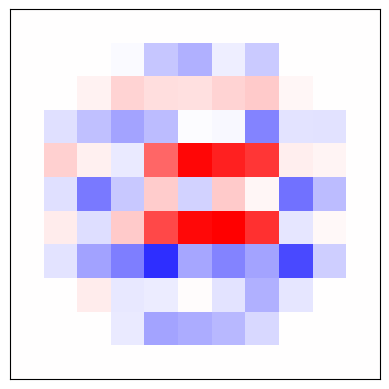

In [10]:
def plot_eigenvectors(individual_fit : IndividualFit, save_to_directory : str = None):
	for i in range(0, 5):
		eigenimage = individual_fit.eigenvectors[i]
		eigenimage /= np.max(np.abs(eigenimage))
		plt.imshow(eigenimage, cmap='bwr', interpolation='nearest', norm = colors.SymLogNorm(0.5, vmin=-1, vmax=1))
		plt.yticks([])
		plt.xticks([])
		if save_to_path_prefix is not None:
			path = f"{save_to_directory}/{individual_fit.planet.name}_{individual_fit.visit_name}_eigenimage_{(i+1)}"
			plt.savefig(path + ".png")
			plt.savefig(path + ".pdf")
		plt.show()
		plt.close()

plot_eigenvectors(lhs1478b.individual_fits[0])